In [1]:
%matplotlib inline

import cv2
import imageio
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import trim_mean
from sklearn.cluster import DBSCAN

plt.rcParams.update({'font.size': 2})

# Display Tools

In [2]:
def add_centroids_and_boxes_to_image(image, cells, gif_mode=False):
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    for i in range(len(cells)):
        cell = cells[i]
        state = cell[4]
        if state == -1:
            continue
        elif state == 1:
            color = (0, 255, 0)
        else:
            color = (0, 0, 255)  # cv2 uses BGR
            if gif_mode:  # imageio uses RGB
                color = (255, 0, 0)
        image = cv2.circle(image, cell[0:2], 0, color, 8)
        image = cv2.rectangle(image,
                              (cell[0]-cell[2], cell[1]-cell[3]),
                              (cell[0]+cell[2], cell[1]+cell[3]),
                              color,
                              2)
    return image

def display_centroids(image, cells, dpi=150, save_name=None, mode='cv2'):
    if mode=='matplotlib':
        plt.figure(dpi=dpi)
        plt.imshow(image, interpolation='nearest', cmap='gray')
        overlap_idx = np.where(cells[:,4] == 1)[0]
        lost_idx = np.where(cells[:,4] == -1)[0]
        if len(overlap_idx) > 0:
            plt.scatter(*zip(*cells[overlap_idx,0:2]), c='lime', marker='+')
        r_cells = np.delete(cells, np.append(overlap_idx,lost_idx), axis=0)
        plt.scatter(*zip(*r_cells[:,0:2]), c='r', marker='+')
        if save_name is not None:
            plt.savefig('saved_images/' + save_name + '.png', bbox_inches='tight')
        else:
            plt.show()
        plt.close()
    elif mode=='cv2':
        image = add_centroids_and_boxes_to_image(image, cells)
        if save_name is not None:
            cv2.imwrite('saved_images/' + save_name + '.png', image)
        else:
            plt.figure(dpi=dpi)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

def display_image_array(im_arr, columns=7, dpi=240):
    rows = int(len(im_arr) / columns) + 1
    plt.figure(dpi=dpi)
    for i in range(len(im_arr)):
        plt.subplot(rows,columns,i+1)
        plt.imshow(im_arr[i], interpolation='nearest', cmap='gray')
    plt.show()

def get_sub_images(image, cells):
    boxes = []
    for i in range(len(cells)):
        x, y, box_x, box_y, state = cells[i]
        box = image[max(y-box_y, 0):min(y+box_y, image.shape[0]),
                    max(x-box_x, 0):min(x+box_x, image.shape[1])]
        boxes += [box,]
    return boxes

# Image Processing Pipeline

In [3]:
def apply_canny(image, threshold1=100, threshold2=230):
    return cv2.Canny(np.uint8(image), threshold1=threshold1, threshold2=threshold2)

def apply_closure(image, kernel_size=5):
    kernel = np.ones((kernel_size,kernel_size),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

def apply_imfill(image):
    t = image.copy()
    y_dim, x_dim = image.shape
    mask = np.zeros((y_dim+2,x_dim+2), np.uint8)
    t = cv2.floodFill(t, mask, (0,0), 255)[1]
    t = cv2.floodFill(t, mask, (0, y_dim-1), 255)[1]
    t = cv2.floodFill(t, mask, (x_dim-1, 0), 255)[1]
    t = cv2.floodFill(t, mask, (x_dim-1, y_dim-1), 255)[1]
    return image | cv2.bitwise_not(t)

def apply_impipeline(image):
    return apply_imfill(apply_closure(apply_canny(image)))

# Input:
#  - image: binary image
#  - threshold [0-1]: only remove elements less that make up less than threshold
#                     amount of total elements
#  - connectivity: 4 to exclude diagonals, 8 to include
def remove_secondary_elements(image, threshold=0.4, connectivity=8):
    imtype = image.dtype
    num_components, labelled, stats, centroids = \
        cv2.connectedComponentsWithStats(image, connectivity)
    
    # There is nothing in the image (the whole image is the component)
    if num_components == 1:
        return image
    
    component_sizes = stats[1:,-1]  # label 0 is the background component
    total_size = sum(component_sizes)
    largest_component = np.argmax(component_sizes) + 1

    for c in range(1, num_components):  # label 0 is the background component
        if c == largest_component:
            continue
        component = (labelled == c).astype(int)
        if np.sum(component) < threshold*total_size:
            image = image & (1-component)
    
    return image.astype(imtype)

# Iteration Logic

In [4]:
# Takes a list of (x, y) coordinates corresponding to points in the cluster.
# This cluster is presumed to be INaccurate, so we trim the outliers.
def compute_approx_centroid(cluster):
    y = int(trim_mean(cluster[:, 0], 0.25))
    x = int(trim_mean(cluster[:, 1], 0.25))
    return x, y

# Returns True if both cells are within each other's bounding boxes.
def is_overlapping(cell1, cell2):
    x1, y1, box_x1, box_y1, state = cell1
    x2, y2, box_x2, box_y2, state = cell2
    return x1 > x2-box_x2 and x1 < x2+box_x2 and \
           y1 > y2-box_y2 and y1 < y2+box_y2 and \
           x2 > x1-box_x1 and x2 < x1+box_x1 and \
           y2 > y1-box_y1 and y2 < y1+box_y1

# Overlap centroids if they are within each other's bounding boxes.
# Note that this modifies cells in-place.
def dedup_centroids(cells):
    num_cells = len(cells)
    cell_overlap = np.identity(num_cells)

    # Establish overlapping cells
    for i in range(num_cells):
        for j in range(i+1, num_cells):
            if is_overlapping(cells[i], cells[j]):
                cell_overlap[i][j] = 1
                cell_overlap[j][i] = 1
    
    for i in range(num_cells):
        if sum(cell_overlap[i]) == 1:  # cell is alone
            continue
        else:
            c = np.argwhere(cell_overlap[i])
            cf = c.flatten()
            # Do cool tricks here; establishes if all cells overlapping with
            # cells[i] overlap with each other
            if np.sum(cell_overlap[cf, c]) == sum(cell_overlap[i])**2 and \
               np.sum(np.delete(cell_overlap[cf], cf, axis=1)) == 0 and \
               np.sum(np.delete(cell_overlap[:, cf], cf, axis=0)) == 0:
                new_x = int(np.mean(cells[cf][:,0]))
                new_y = int(np.mean(cells[cf][:,1]))
                new_box_x = max(new_x - min(cells[cf][:,0] - cells[cf][:,2]),
                                max(cells[cf][:,0] + cells[cf][:,2]) - new_x)
                new_box_y = max(new_y - min(cells[cf][:,1] - cells[cf][:,3]),
                                max(cells[cf][:,1] + cells[cf][:,3]) - new_y)
                cells[cf] = [new_x, new_y, new_box_x, new_box_y, 1]
                cell_overlap[cf, c] = np.identity(len(cf))

# Using new_image, update the centroids in cells. Note that this modifies
# cells in-place.
def update_tracking(new_image, cells, debug=False):
    new_image = apply_impipeline(new_image)
    
    for i in range(len(cells)):
        x, y, box_x, box_y, state = cells[i]
        
        # box should not exceed bounds of image
        box = new_image[max(y-box_y, 0):min(y+box_y, new_image.shape[0]),
                        max(x-box_x, 0):min(x+box_x, new_image.shape[1])]

        if len(box) == 0:
            cells[i][4] = -1
            continue
        filtered = remove_secondary_elements(box)
        cluster = np.argwhere(filtered)
        
        # Need to ensure cell is inside the box
        if len(cluster) > 0:
            sub_x, sub_y = compute_approx_centroid(cluster)
            
            if debug:
                display_centroids(box, [[sub_x, sub_y],], dpi=50)
                display_centroids(filtered, [[sub_x, sub_y],], dpi=50)

            cells[i][0] = max(x-box_x, 0) + sub_x
            cells[i][1] = max(y-box_y, 0) + sub_y
        else:
            cells[i][4] = -1
            if debug:
                plt.figure(dpi=dpi)
                plt.imshow(box, interpolation='nearest', cmap='gray')
                plt.show()

# Read initial image and find centroids

Image dimensions: (832, 1128)


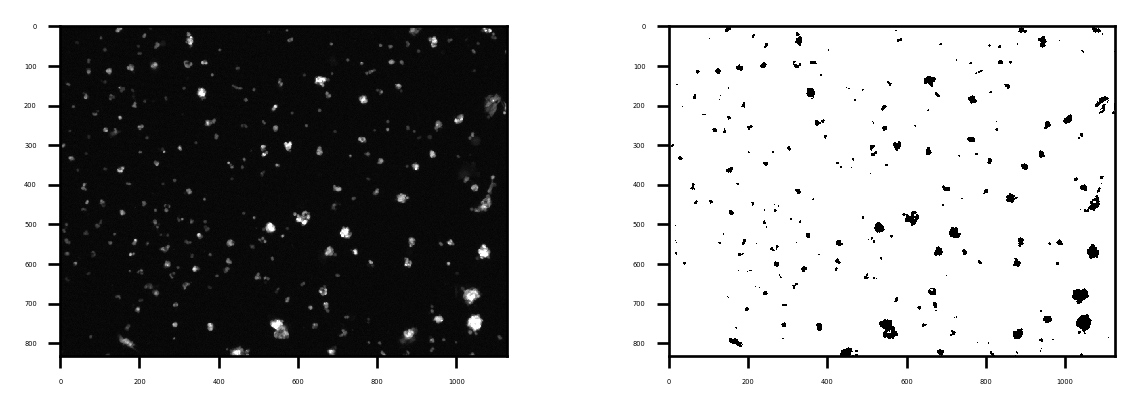

In [5]:
rfp = cv2.imreadmulti('RFP-1.tif')[1]

initial_image = rfp[0]

# 0 is a throwaway param, Otsu will determine
threshold, binarized = \
    cv2.threshold(initial_image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
initial_binarized = (initial_image < threshold).astype(int)

coordinate_bounds = initial_image.shape
print("Image dimensions: " + str(coordinate_bounds))

display_image_array([initial_image, initial_binarized], columns=2)

In [6]:
# Takes a list of (x, y) coordinates corresponding to points in the cluster.
# This cluster is presumed to be accurate, so we use all values given.
# Output:
#  - x, y: the centroid
#  - box_x: x distance from the centroid for the bounding box
#  - box_y: y distance from the centroid for the bounding box
def compute_centroid_and_box(cluster):
    x = int(np.mean(cluster[:, 1]))
    size_x = np.max(cluster[:, 1]) - np.min(cluster[:, 1])
    box_x = int(1.5*size_x)

    y = int(np.mean(cluster[:, 0]))
    size_y = np.max(cluster[:, 0]) - np.min(cluster[:, 0])
    box_y = int(1.5*size_y)
    
    return x, y, box_x, box_y

Tracking 58 cells


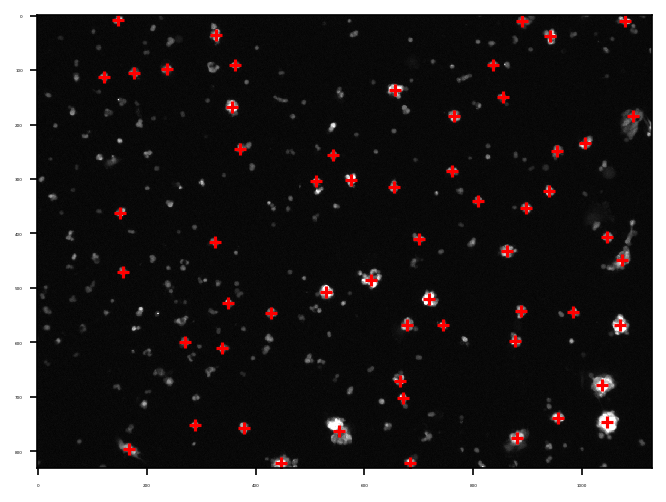

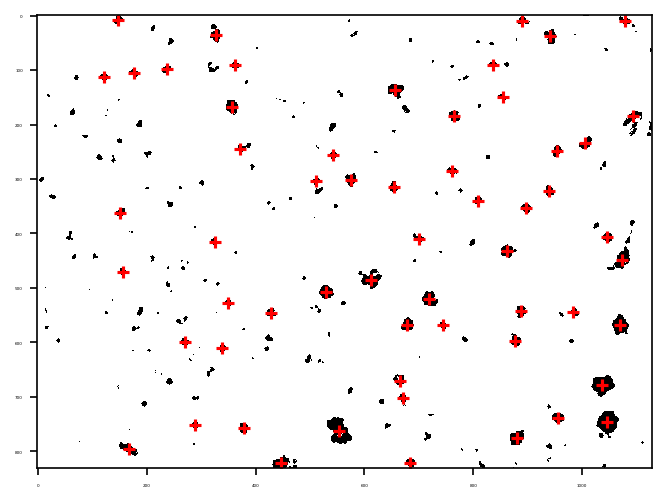

In [7]:
cell_points = np.argwhere(1-initial_binarized)
clustering = DBSCAN(eps=6, min_samples=100).fit(cell_points)
labels = clustering.labels_

# Store cells as [[centroid, box_x, box_y], ...]
cells = []
state = 0  # track the state of the cell

# Note that clustering.labels_ includes -1, which are noisy samples.
# Thus, enforce starting at 0 rather than min(labels).
for i in range(0, max(labels)+1):
    indices = np.where(labels == i)
    cluster = cell_points[indices]
    x, y, box_x, box_y = compute_centroid_and_box(cluster)
    cells += [[x, y, box_x, box_y, state],]
    
cells = np.array(cells)

print("Tracking %i cells" % len(cells))
display_centroids(initial_image, cells, mode='matplotlib')
display_centroids(initial_binarized, cells, mode='matplotlib')

# Proof of Concept for LoG

In [8]:
# image = rfp[1]
# x, y, box_x, box_y, state = cells[2]
# box = image[max(y-box_y, 0):min(y+box_y, image.shape[0]),
#             max(x-box_x, 0):min(x+box_x, image.shape[1])]

# # LoG
# blurred = cv2.GaussianBlur(np.float64(box), (3,3), 0)
# filtered = cv2.Laplacian(np.float64(blurred), cv2.CV_64F)
# edges = (filtered == 0).astype(int)  # need to threshold this

# display_image_array([box, blurred, filtered, edges], columns=4)

# Proof of Concept for Image Processing Pipeline

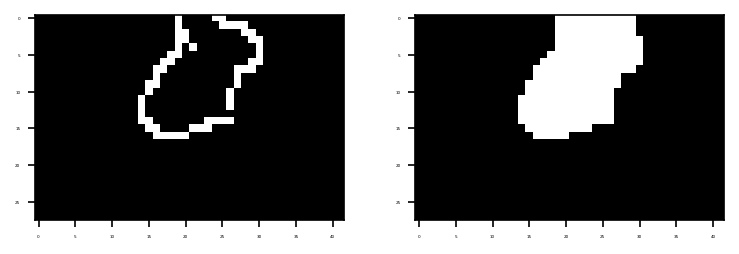

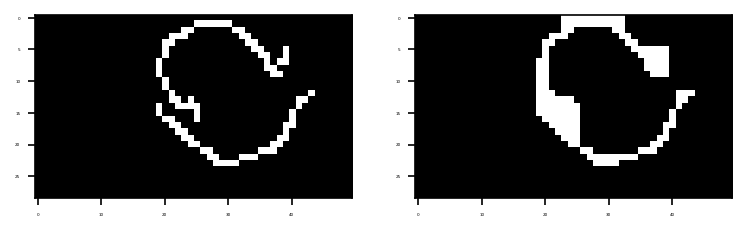

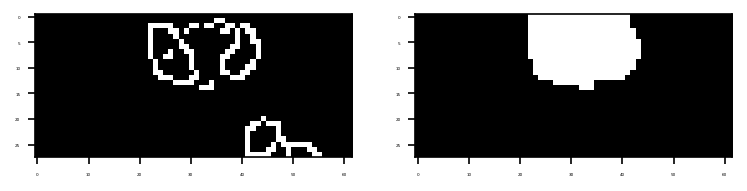

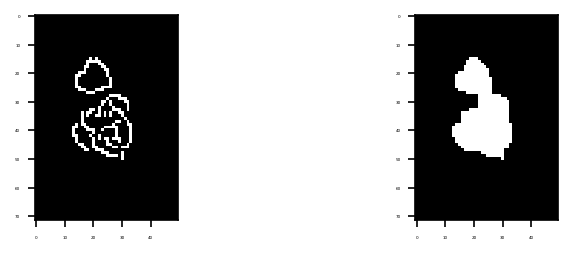

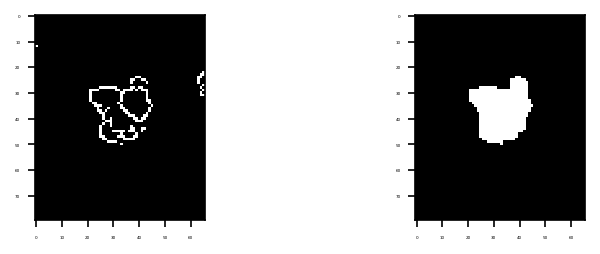

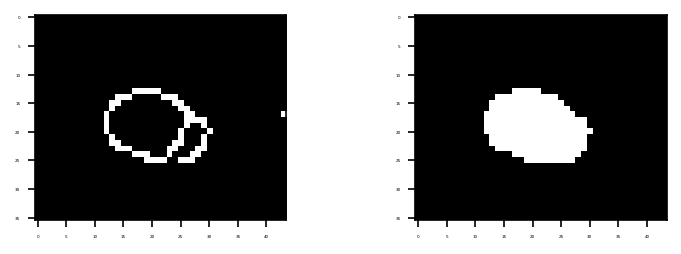

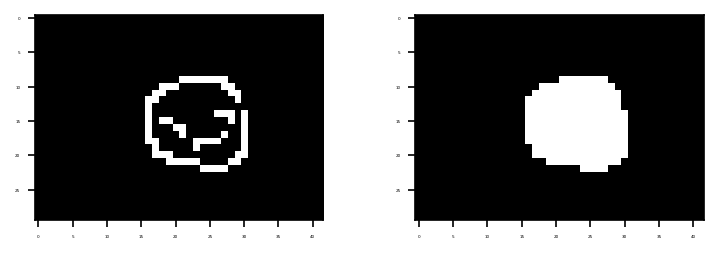

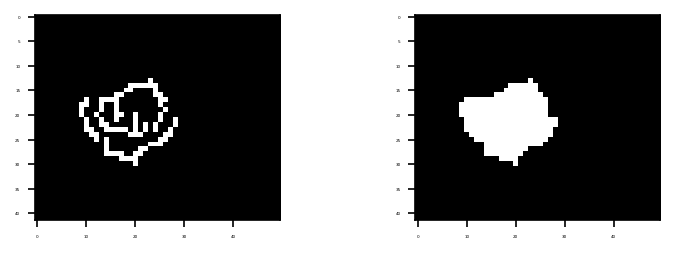

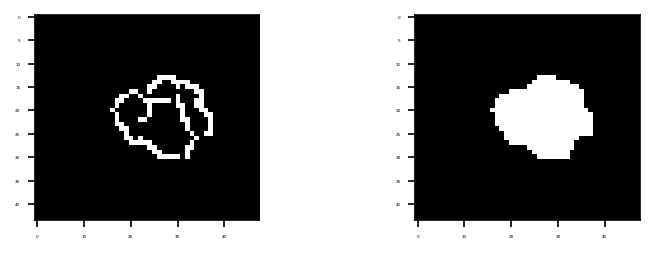

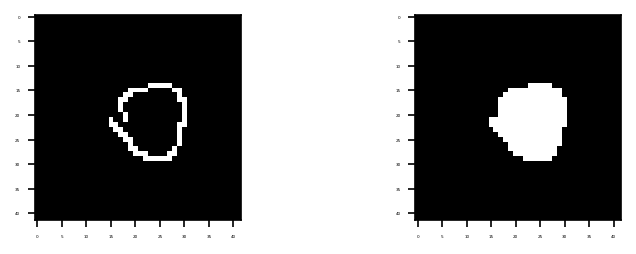

In [9]:
im_canny = apply_canny(rfp[1])
im_pipeline = apply_impipeline(rfp[1])
for i in range(10): # len(cells)):
    x, y, box_x, box_y, state = cells[i]
    box_canny = im_canny[max(y-box_y, 0):min(y+box_y, im_canny.shape[0]),
                         max(x-box_x, 0):min(x+box_x, im_canny.shape[1])]
    box_pipeline= im_pipeline[max(y-box_y, 0):min(y+box_y, im_pipeline.shape[0]),
                              max(x-box_x, 0):min(x+box_x, im_pipeline.shape[1])]
    display_image_array([box_canny, remove_secondary_elements(box_pipeline)], columns=2, dpi=150)

# Pipeline sanity check

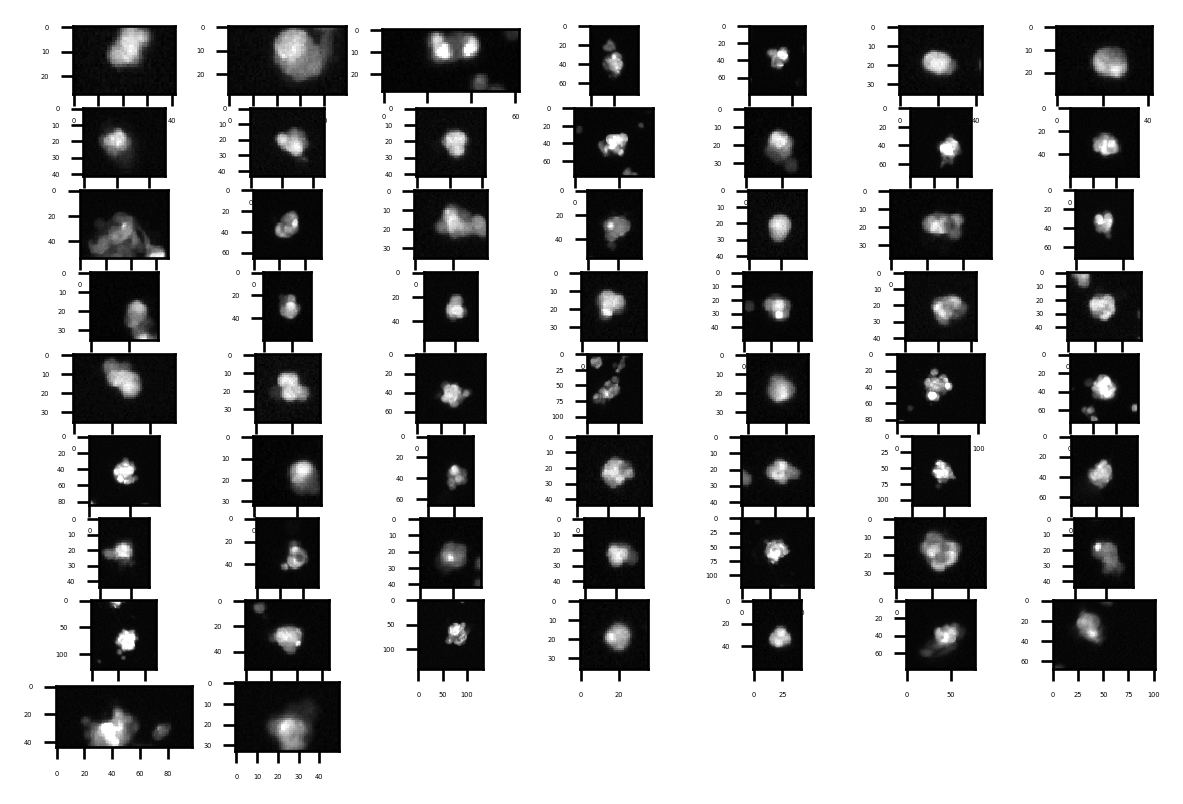

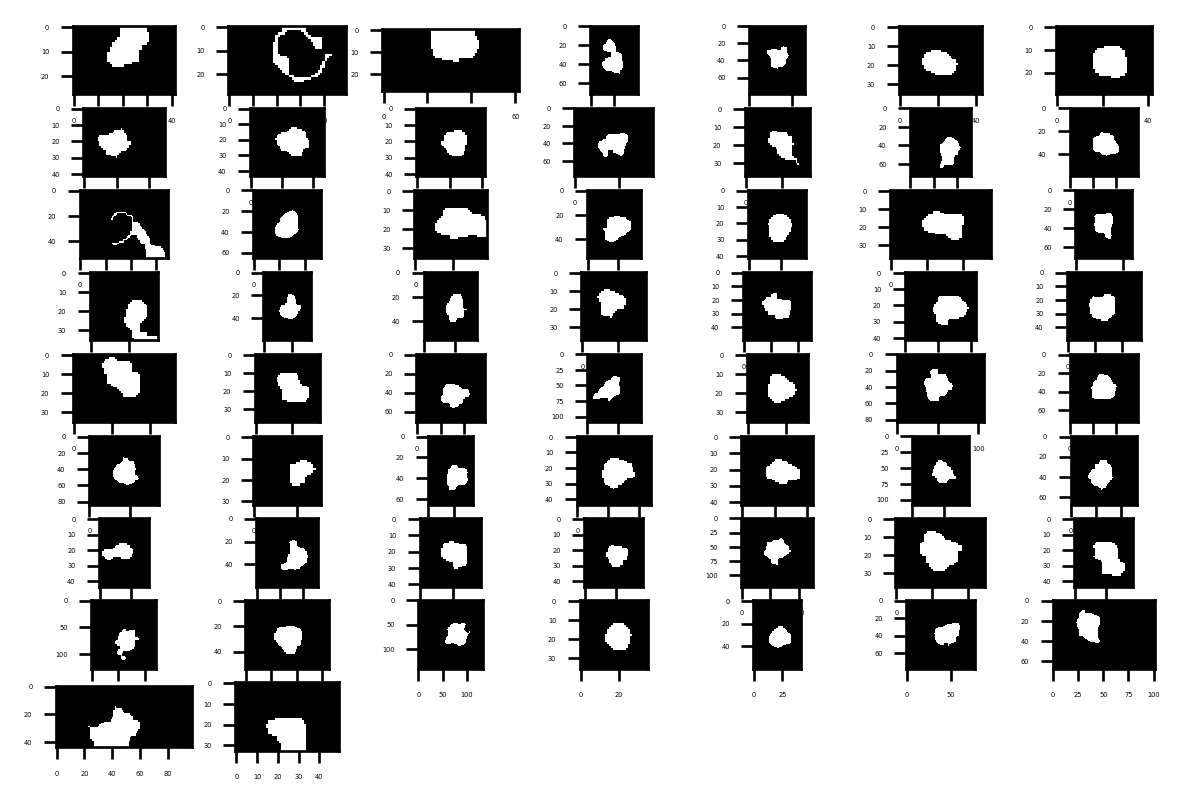

In [10]:
raw_boxes = get_sub_images(rfp[1], cells)
processed_boxes = get_sub_images(apply_impipeline(rfp[1]), cells)
display_image_array(raw_boxes)
display_image_array([remove_secondary_elements(box) for box in processed_boxes])

# Iterate on all images

In [11]:
gif_buffer = []
for i in range(1, len(rfp)):
    image = rfp[i]
    update_tracking(image, cells, debug=False)
    dedup_centroids(cells)
    display_centroids(image, cells, save_name=str(i))
    gif_buffer.append(add_centroids_and_boxes_to_image(image, cells, gif_mode=True))
imageio.mimsave('centroids.gif', gif_buffer, duration=0.4)

![](centroids.gif)